In [2]:
import jax
import jax.numpy as jnp
from tqdm import tqdm
import netket as nk
import netket.jax as nkjax
# import netket_pro as nkp
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
from tqdm import tqdm
import jax.numpy as jnp
import jax
from grad_sample.utils.misc import compute_eloc
from grad_sample.utils.distances import curved_dist, fs_dist, param_overlap
from hydra import compose, initialize, initialize_config_dir
from omegaconf import OmegaConf
from hydra.core.global_hydra import GlobalHydra
from hydra.utils import instantiate
from grad_sample.tasks.fullsum_analysis import FullSumPruning
from grad_sample.tasks.fullsum_train import Trainer
from grad_sample.utils.is_distrib import *
# from grad_sample.utils.plotting_setup import *
from grad_sample.is_hpsi.expect import *
from grad_sample.is_hpsi.qgt import QGTJacobianDenseImportanceSampling
from grad_sample.is_hpsi.operator import IS_Operator

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib import colors
mc_sample = 9 #2**mc_sample samples
is_keys = [ "0.0",  "0.5", "1.0", "2.0"]
for key in is_keys:
    out_dict = {}
    # Define the main folder
    main_folder = f"/scratch/.amisery/grad_sample_mc_hparams/xxz_1.5/L16/RBM/alpha3/MC_{mc_sample}_{key}"

    # Store the minimum rel_err for each combination of a and b
    rel_err_data = defaultdict(lambda: 100.)

    # Iterate through subfolders
    for subfolder in os.listdir(main_folder):
        subfolder_path = os.path.join(main_folder, subfolder)

        # Check if the subfolder name is in the form a_b
        try:
            a, b = map(float, subfolder.split('_'))
        except ValueError:
            continue  # Skip folders not in the correct format

        # Process run log files in the subfolder
        if os.path.isdir(subfolder_path):
            for file in os.listdir(subfolder_path):
                if file.startswith("run_") and file.endswith(".log"):
                    file_path = os.path.join(subfolder_path, file)
                    try:
                        with open(file_path, 'r') as f:
                            log_data = json.load(f)
                            rel_err = log_data["rel_err"]["value"]
                            if None in rel_err:
                                m = 100
                            else: 
                                m = min(rel_err)
                            rel_err_data[(a, b)] = min(rel_err_data[(a, b)], m)
                    except (json.JSONDecodeError, KeyError):
                        print(f"Warning: Could not parse file {file_path}")

    # Prepare data for the heatmap
    all_a = sorted(set(key[0] for key in rel_err_data.keys()))
    all_b = sorted(set(key[1] for key in rel_err_data.keys()))

    # Create a 2D grid for a and b
    heatmap = np.full((len(all_a), len(all_b)), np.nan)


[0.0001, 0.0008071428571428572, 0.001, 0.0015142857142857143, 0.002096, 0.0022214285714285712, 0.0029285714285714284, 0.0036357142857142855, 0.004092, 0.004342857142857143, 0.00505, 0.005757142857142857, 0.006088, 0.006464285714285714, 0.007171428571428572, 0.00787857142857143, 0.008084, 0.008585714285714285, 0.009292857142857143, 0.01]
[0.0001, 0.0005, 0.0008071428571428572, 0.001, 0.0015142857142857143, 0.0022, 0.0022214285714285712, 0.0029285714285714284, 0.0036357142857142855, 0.004342857142857143, 0.005, 0.00505, 0.005757142857142857, 0.006464285714285714, 0.007171428571428572, 0.00787857142857143, 0.008585714285714285, 0.009292857142857143, 0.01, 0.05]
[0.0001, 0.0005, 0.0008071428571428572, 0.001, 0.0015142857142857143, 0.002, 0.0022, 0.0022214285714285712, 0.0029285714285714284, 0.0036357142857142855, 0.004342857142857143, 0.005, 0.00505, 0.005757142857142857, 0.006464285714285714, 0.007171428571428572, 0.00787857142857143, 0.008585714285714285, 0.009292857142857143, 0.01, 0.05

Text(0, 0.5, 'relative error wrt ed')

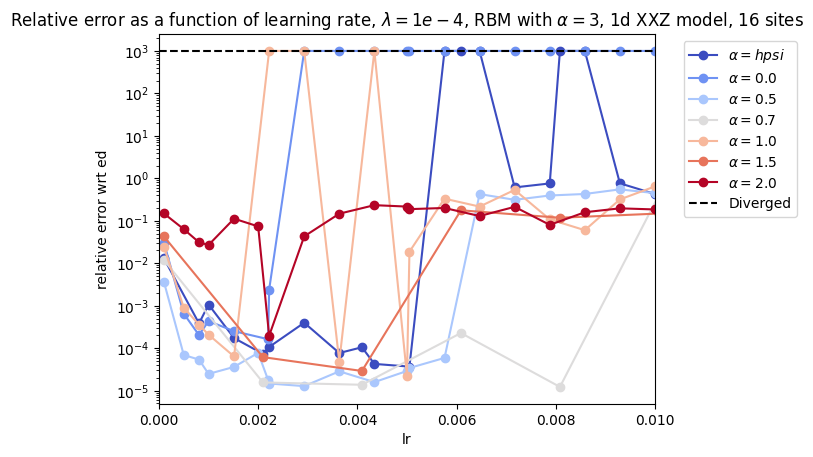

In [5]:
import os
import re
import json
from matplotlib.cm import viridis, seismic, coolwarm, Spectral

def find_matching_folders_and_files(base_folder):
    # Regex patterns for folder and file matching
    folder_pattern = re.compile(r'^\d+(\.\d+)_0.0001$')  # Matches 'a_0.0001' where 'a' is a float
    file_pattern = re.compile(r'^run_\d.log$')  # Matches 'run_b.log' where 'b' is a float

    results = []

    # Walk through the directory
    for root, dirs, files in os.walk(base_folder):
        for dir_name in dirs:
            if folder_pattern.match(dir_name):
                folder_path = os.path.join(root, dir_name)
                
                for file_name in os.listdir(folder_path):
                    
                    if file_pattern.match(file_name):
                        results.append((folder_path, file_name))

    return results

is_keys = ['hpsi', "0.0", "0.5", '0.7', "1.0", '1.5', "2.0"]

colors = coolwarm(jnp.linspace(0, 1,len(is_keys)))
i=0
for key in is_keys:
    out_dict = {}
    # Specify the folder to search
    mc_sample = 9
    base_folder = f"/scratch/.amisery/grad_sample_mc_hparams/xxz_1.5/L16/RBM/alpha3/MC_{mc_sample}_{key}"

    # Find matching folders and files
    matches = find_matching_folders_and_files(base_folder)
    for folder, file in matches:
        match = re.search(r"/([\d.]+)_", folder)
        lr = float(match.group(1))
        if lr not in out_dict.keys():
            out_dict[lr] = 1000
        run_dir_path = os.path.join(folder, file)
        with open(run_dir_path, 'r') as f:
            log_data = json.load(f)
            rel_err = log_data["rel_err"]["value"]
            if None in rel_err:
                m = 1000
            else: 
                m = min(rel_err)
            out_dict[lr] = min(out_dict[lr], m)
    # Check if the subfolder name is in the form a_b
    sorted_items = jnp.array(sorted(out_dict.items()))

    def get_sorted_keys_and_values(input_dict):
        """
        Returns the keys and values of a dictionary sorted by the keys.

        Args:
            input_dict (dict): The input dictionary.

        Returns:
            tuple: A tuple containing two lists - sorted keys and their corresponding values.
        """
        sorted_keys = sorted(input_dict.keys())
        print(sorted_keys)
        sorted_values = [input_dict[key] for key in sorted_keys]
        return sorted_keys, sorted_values


    sorted_keys, sorted_vals = get_sorted_keys_and_values(out_dict)
    plt.plot(sorted_keys, sorted_vals, '-o', label= r'$\alpha=%s$'%key, color=colors[i])
    i+=1
    # plt.scatter(out_dict.keys(), out_dict.values(),label= r'$\alpha=%s$'%key)
    # if sorted_items.size > 0:
    #     plt.plot(sorted_items[:,0], sorted_items[:,1],label= r'$\alpha=%s$'%key)
fs_res = json.load(open('/home/amisery/scratch_link/grad_sample/xxz_1.5/L16/RBM/alpha3/saved_10_3.log'))
print(fs_res.keys())
# plt.xlim(min(out_dict.keys()),0.1)
plt.title(r'Relative error as a function of learning rate, $\lambda = 1e-4$, RBM with $\alpha = 3$, 1d XXZ model, 16 sites')
plt.hlines(1e3, 0, 0.01, color='black', linestyles='--', label='Diverged')
plt.yscale('log')
# plt.xscale('log')
plt.xlim(0, 0.01)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.xlabel('lr')
plt.ylabel('relative error wrt ed')

/tmp/ipykernel_656507/1006089979.py:57: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.5, 1))


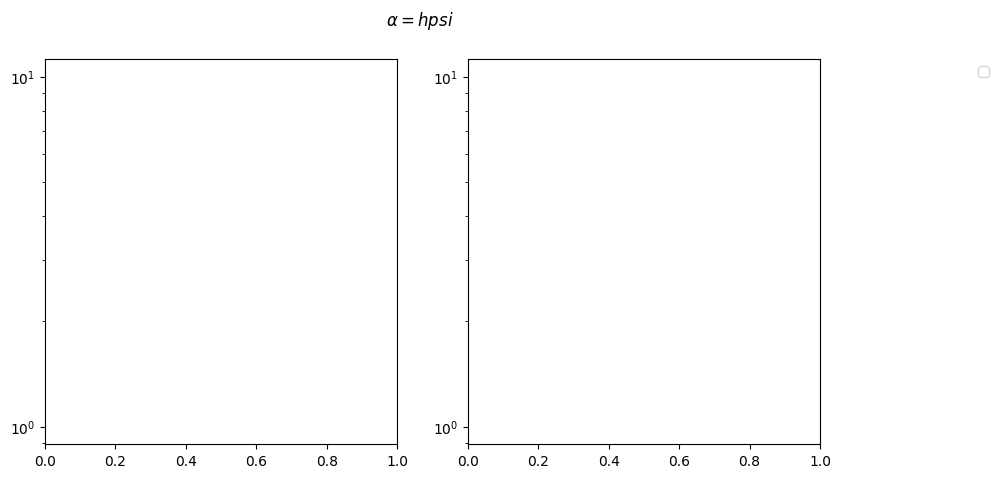

<Figure size 640x480 with 0 Axes>

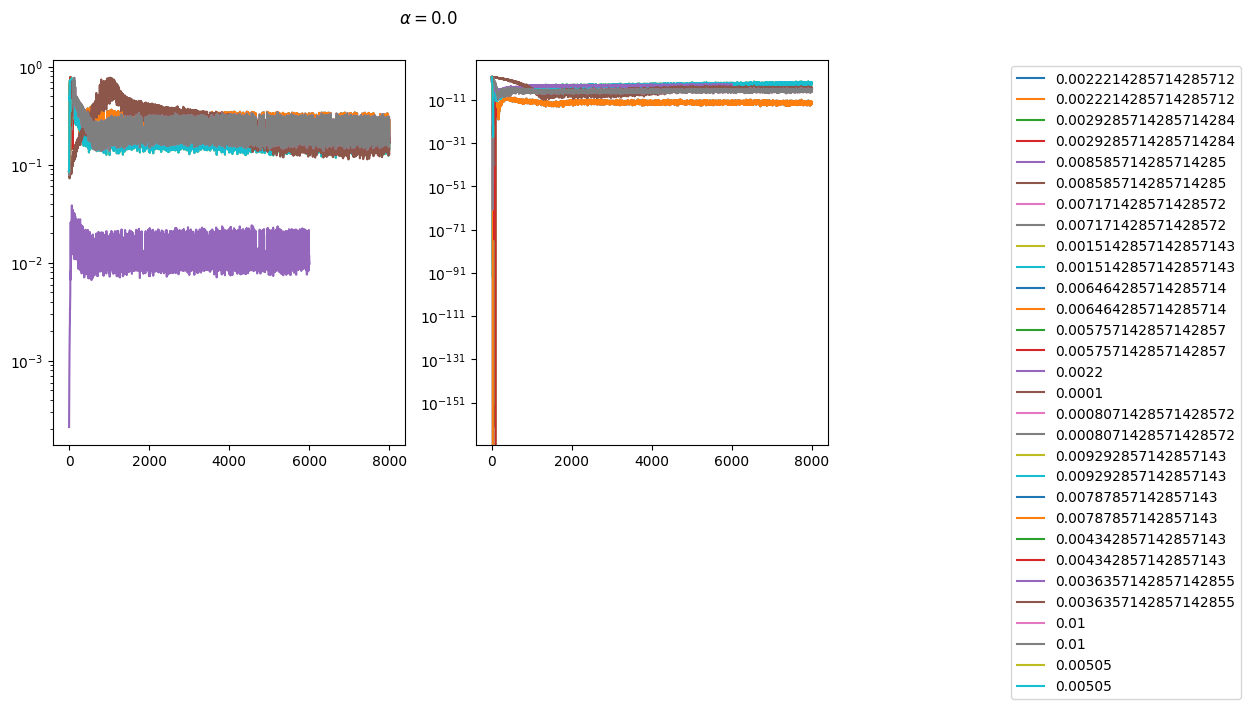

<Figure size 640x480 with 0 Axes>

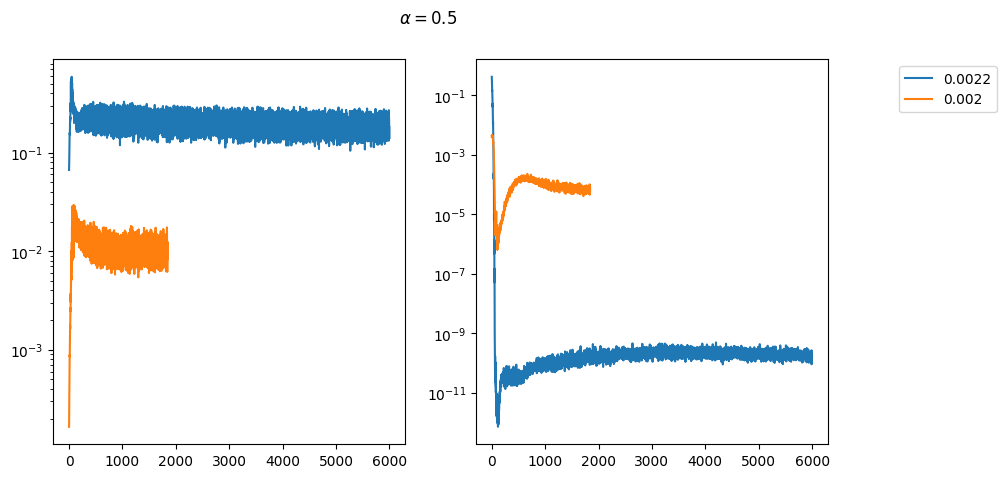

<Figure size 640x480 with 0 Axes>

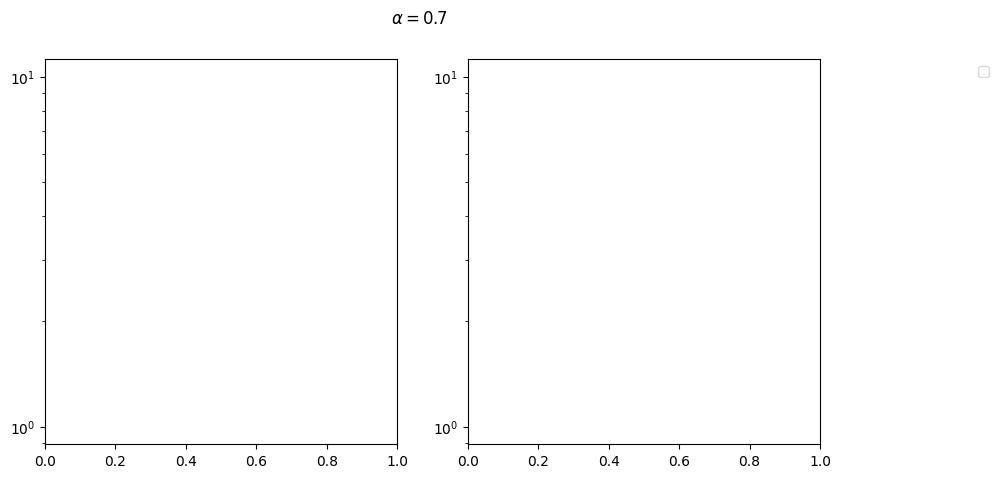

<Figure size 640x480 with 0 Axes>

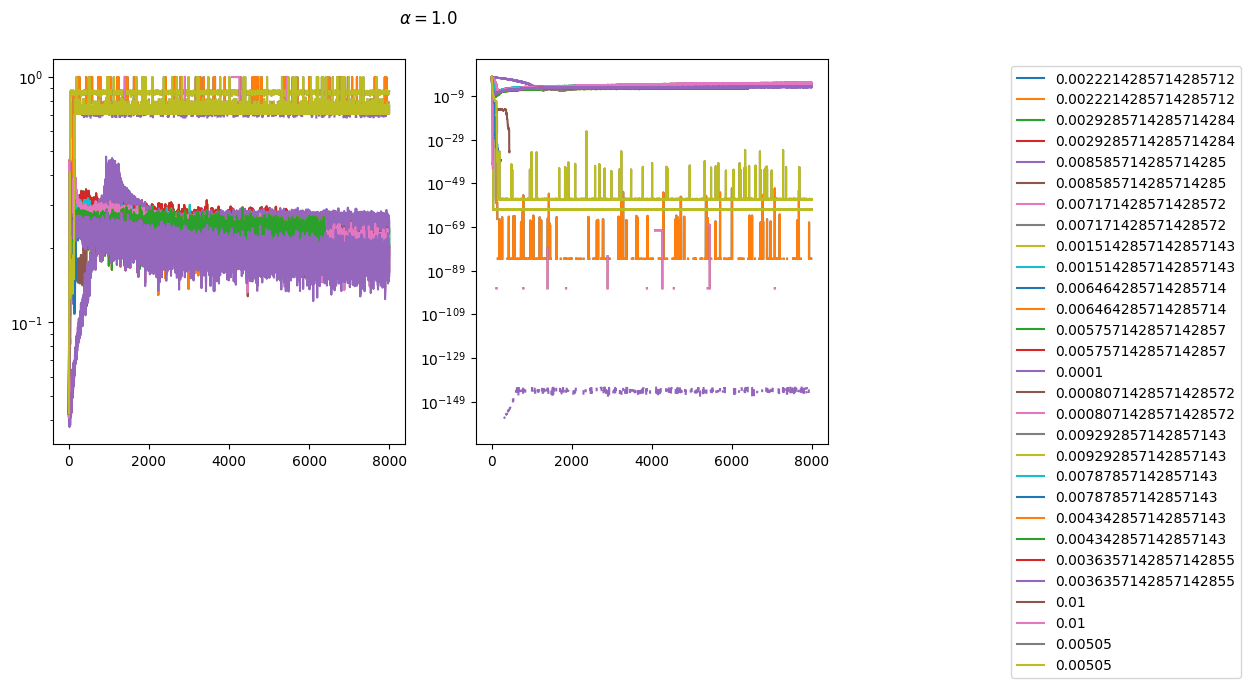

<Figure size 640x480 with 0 Axes>

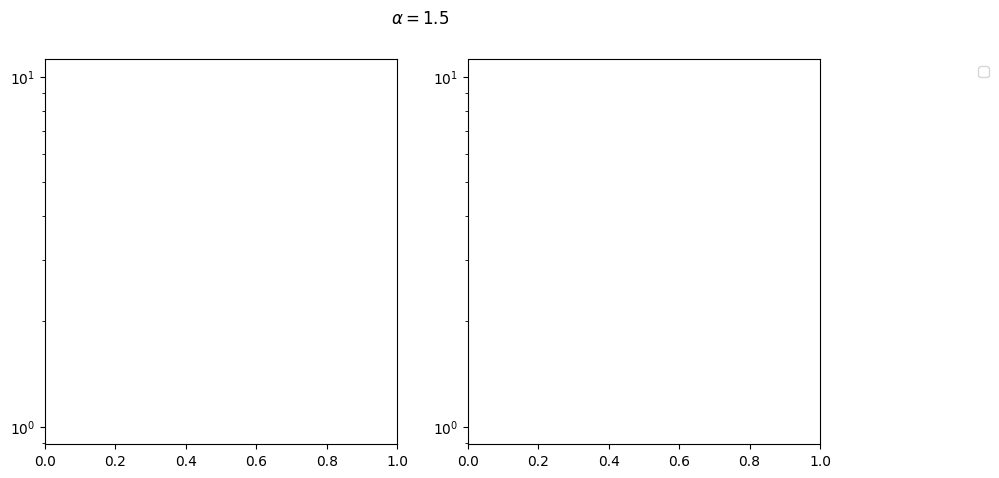

<Figure size 640x480 with 0 Axes>

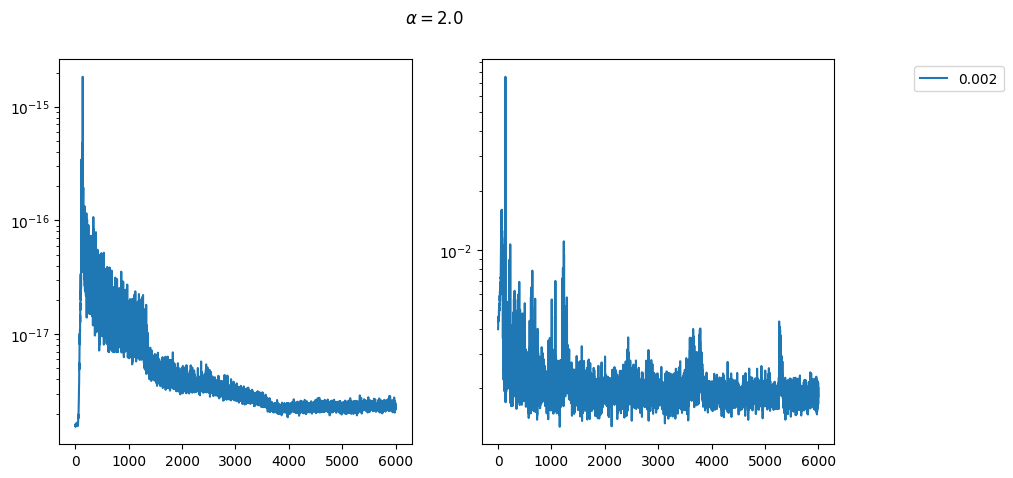

dict_keys(['Energy'])


Text(0, 0.5, 'relative error wrt ed')

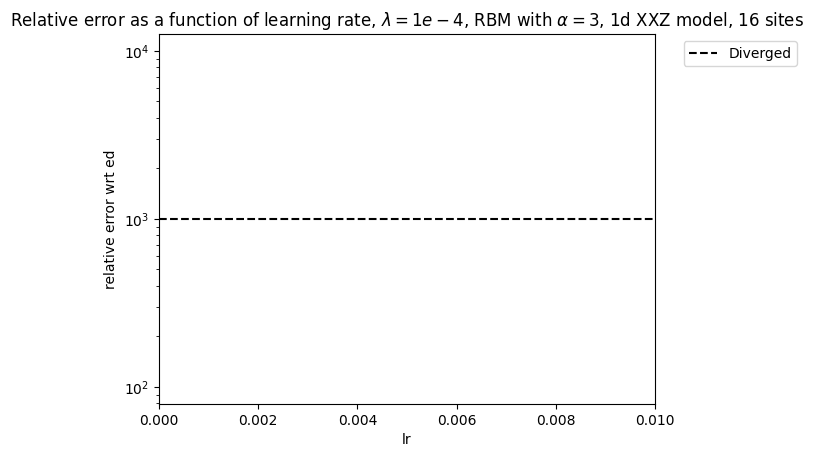

In [6]:
import os
import re
import json
from matplotlib.cm import viridis, seismic, coolwarm, Spectral

def find_matching_folders_and_files(base_folder):
    # Regex patterns for folder and file matching
    folder_pattern = re.compile(r'^\d+(\.\d+)_0.0001$')  # Matches 'a_0.0001' where 'a' is a float
    file_pattern = re.compile(r'^run_\d.log$')  # Matches 'run_b.log' where 'b' is a float

    results = []

    # Walk through the directory
    for root, dirs, files in os.walk(base_folder):
        for dir_name in dirs:
            if folder_pattern.match(dir_name):
                folder_path = os.path.join(root, dir_name)
                
                for file_name in os.listdir(folder_path):
                    
                    if file_pattern.match(file_name):
                        results.append((folder_path, file_name))

    return results

is_keys = ['hpsi', "0.0", "0.5", '0.7', "1.0", '1.5', "2.0"]

colors = coolwarm(jnp.linspace(0, 1,len(is_keys)))
i=0
for key in is_keys:
    fig, axes = plt.subplots(1,2, figsize=(10,5))
    axes[0].set_yscale('log')
    axes[1].set_yscale('log')
    out_dict = {}
    # Specify the folder to search
    mc_sample = 9
    base_folder = f"/scratch/.amisery/grad_sample_mc_hparams/xxz_1.5/L16/RBM/alpha3/MC_{mc_sample}_{key}"

    # Find matching folders and files
    matches = find_matching_folders_and_files(base_folder)
    for folder, file in matches:
        match = re.search(r"/([\d.]+)_", folder)
        lr = float(match.group(1))
        if lr not in out_dict.keys():
            out_dict[lr] = 1000
        run_dir_path = os.path.join(folder, file)
        with open(run_dir_path, 'r') as f:
            log_data = json.load(f)
            try :
                snr_jac = log_data["snr_jac"]["value"]
                snr_f  = log_data["snr_f"]["value"]
                axes[0].plot(snr_jac, label=lr)
                axes[1].plot(snr_f, label=lr)

            except:
                pass
    plt.legend(bbox_to_anchor=(1.5, 1))
    fig.suptitle(r'$\alpha = %s$'%key)
    plt.show()
    plt.clf()
    # Check if the subfolder name is in the form a_b
    # sorted_items = jnp.array(sorted(out_dict.items()))

    # def get_sorted_keys_and_values(input_dict):
    #     """
    #     Returns the keys and values of a dictionary sorted by the keys.

    #     Args:
    #         input_dict (dict): The input dictionary.

    #     Returns:
    #         tuple: A tuple containing two lists - sorted keys and their corresponding values.
    #     """
    #     sorted_keys = sorted(input_dict.keys())
    #     print(sorted_keys)
    #     sorted_values = [input_dict[key] for key in sorted_keys]
    #     return sorted_keys, sorted_values


    # sorted_keys, sorted_vals = get_sorted_keys_and_values(out_dict)
    # plt.plot(sorted_keys, sorted_vals, '-o', label= r'$\alpha=%s$'%key, color=colors[i])
    # i+=1
    # plt.scatter(out_dict.keys(), out_dict.values(),label= r'$\alpha=%s$'%key)
    # if sorted_items.size > 0:
    #     plt.plot(sorted_items[:,0], sorted_items[:,1],label= r'$\alpha=%s$'%key)
fs_res = json.load(open('/home/amisery/scratch_link/grad_sample/xxz_1.5/L16/RBM/alpha3/saved_10_3.log'))
print(fs_res.keys())
# plt.xlim(min(out_dict.keys()),0.1)
plt.title(r'Relative error as a function of learning rate, $\lambda = 1e-4$, RBM with $\alpha = 3$, 1d XXZ model, 16 sites')
plt.hlines(1e3, 0, 0.01, color='black', linestyles='--', label='Diverged')
plt.yscale('log')
# plt.xscale('log')
plt.xlim(0, 0.01)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.xlabel('lr')
plt.ylabel('relative error wrt ed')

## Analysis : SNR of gradients and normalization over training

looking at the plot above, we find the best learning rate for each distribution and look at the SNR of the gradient and the effective sample size (related to the easiness of estimating the ratio ofnormalization constants) over training. For $lr= 0.0022$, the results looks good for most distribution.

In [8]:
import json
import os
import matplotlib.pyplot as plt
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
snr_log = json.load(open('/home/amisery/scratch_link/grad_sample_mc_hparams/xxz_1.5/L16/RBM/alpha3/MC_9_0.5/0.002_0.0001/run_2.log'))
snr_log = json.load(open('/home/amisery/scratch_link/grad_sample_mc_hparams/xxz_1.5/L16/RBM/alpha3/MC_9_2.0/0.002_0.0001/run_0.log'))
snr_log = json.load(open('/home/amisery/scratch_link/grad_sample_mc_hparams/xxz_1.5/L16/RBM/alpha3/MC_9_0.0/0.0022_0.0001/run_0.log'))
snr_log = json.load(open('/home/amisery/scratch_link/grad_sample_mc_hparams/xxz_1.5/L16/RBM/alpha3/MC_9_1.99/0.0022_0.0001/run_0.log'))
snr_log_ising_2 = json.load(open('/home/amisery/scratch_link/grad_sample_mc_hparams/ising_1.0/L4/RBM/alpha3/MC_9_2.0/0.0022_1e-07/run_11.log'))
snr_log_ising_17 = json.load(open('/home/amisery/scratch_link/grad_sample_mc_hparams/ising_1.0/L4/RBM/alpha3/MC_9_1.7/0.0022_1e-07/run_8.log'))
snr_log_ising_05 = json.load(open('/home/amisery/scratch_link/grad_sample_mc_hparams/ising_1.0/L4/RBM/alpha3/MC_9_0.5/0.0022_1e-07/run_1.log'))
snr_log_ising_01 = json.load(open('/home/amisery/scratch_link/grad_sample_mc_hparams/ising_1.0/L4/RBM/alpha3/MC_9_0.1/0.0022_1e-07/run_0.log'))

# snr_log_ising_19 = json.load(open('/home/amisery/scratch_link/grad_sample_mc_hparams/ising_1.0/L4/RBM/alpha3/MC_9_1.9/0.0022_1e-07/run_0.log'))

# snr_log_ising_199 = json.load(open('/home/amisery/scratch_link/grad_sample_mc_hparams/ising_1.0/L4/RBM/alpha3/MC_9_1.99/0.0022_1e-07/run_0.log'))
# snr_log_ising_19999 = json.load(open('/home/amisery/scratch_link/grad_sample_mc_hparams/ising_1.0/L4/RBM/alpha3/MC_9_1.9999/0.0022_1e-07/run_0.log'))

/tmp/ipykernel_656507/3190274468.py:3: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  plt.plot(jnp.array(snr_log_ising_01['snr_jac']['value']), label='snr_jac01')


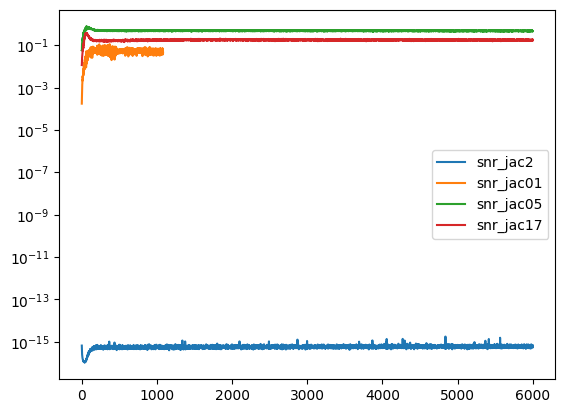

In [9]:
import jax.numpy as jnp
plt.plot(jnp.array(snr_log_ising_2['snr_jac']['value']), label='snr_jac2')
plt.plot(jnp.array(snr_log_ising_01['snr_jac']['value']), label='snr_jac01')
plt.plot(jnp.array(snr_log_ising_05['snr_jac']['value']), label='snr_jac05')
plt.plot(jnp.array(snr_log_ising_17['snr_jac']['value']), label='snr_jac17')
# plt.plot(jnp.array(snr_log_ising_19['snr_jac']['value']), label='snr_jac19')
# plt.plot(jnp.array(snr_log_ising_199['snr_jac']['value']), label='snr_jac199')
# plt.plot(jnp.array(snr_log_ising_19999['snr_jac']['value']), label='snr_jac19999')
# plt.plot(jnp.array(snr_log['snr_f']['value']), label='snr_f')
plt.yscale('log')
plt.legend()

/tmp/ipykernel_656507/4104053953.py:2: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  plt.plot(jnp.array(snr_log_ising_01['snr_f']['value']), label='snr_f01')


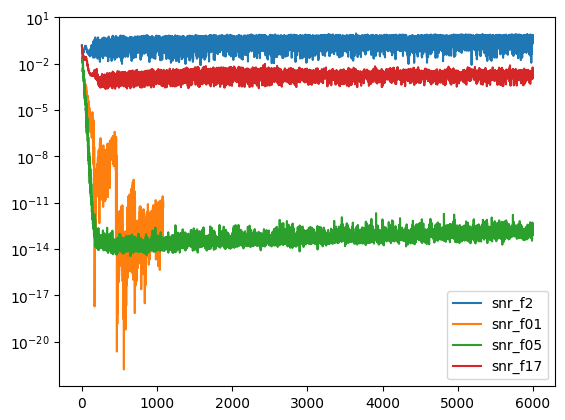

In [10]:
plt.plot(jnp.array(snr_log_ising_2['snr_f']['value']), label='snr_f2')
plt.plot(jnp.array(snr_log_ising_01['snr_f']['value']), label='snr_f01')
plt.plot(jnp.array(snr_log_ising_05['snr_f']['value']), label='snr_f05')
plt.plot(jnp.array(snr_log_ising_17['snr_f']['value']), label='snr_f17')
# plt.plot(jnp.array(snr_log_ising_19['snr_f']['value']), label='snr_f19')
# plt.plot(jnp.array(snr_log_ising_199['snr_f']['value']), label='snr_f199')
# plt.plot(jnp.array(snr_log_ising_19999['snr_f']['value']), label='snr_f19999')
plt.yscale('log')
plt.legend()

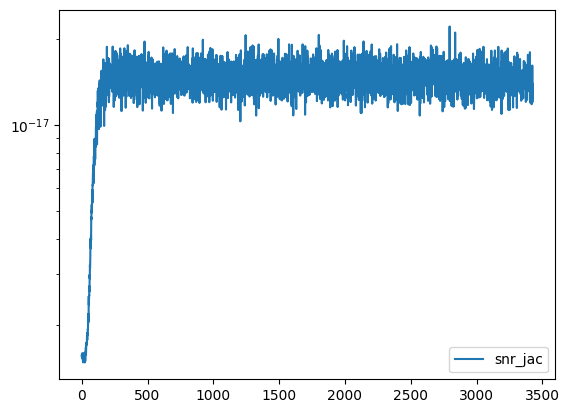

: 

: 

: 

In [62]:
import jax.numpy as jnp
plt.plot(jnp.array(snr_log['snr_jac']['value']), label='snr_jac')
# plt.plot(jnp.array(snr_log['snr_f']['value']), label='snr_f')
plt.yscale('log')
plt.legend()

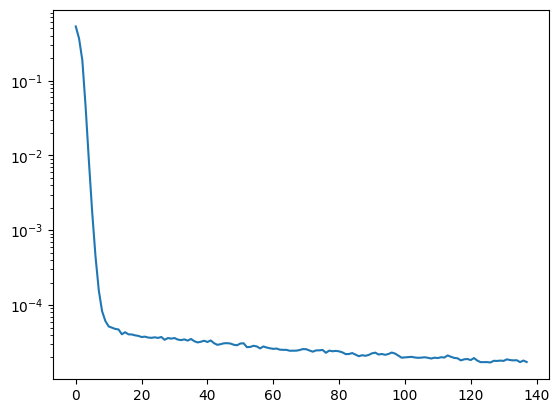

: 

: 

: 

In [64]:
plt.plot(snr_log['rel_err']['value'])
plt.yscale('log')

: 

: 

: 

(39, 13)


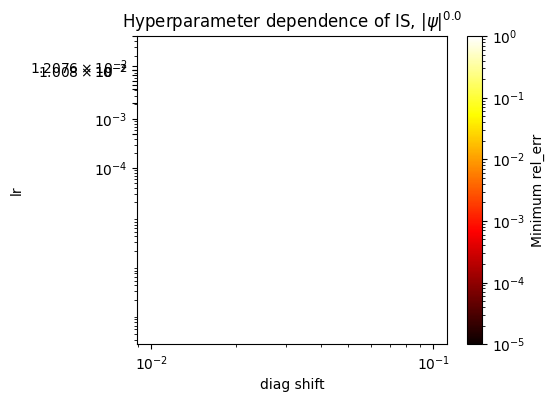

(39, 12)


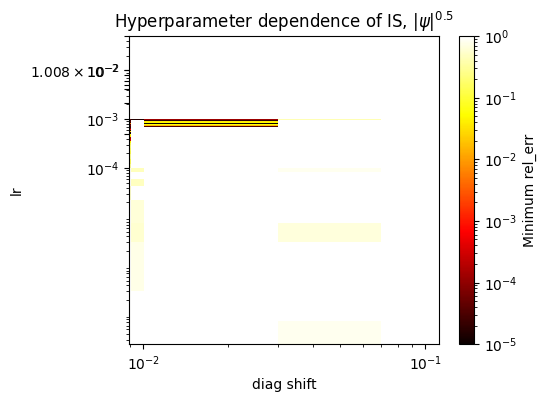

(39, 25)


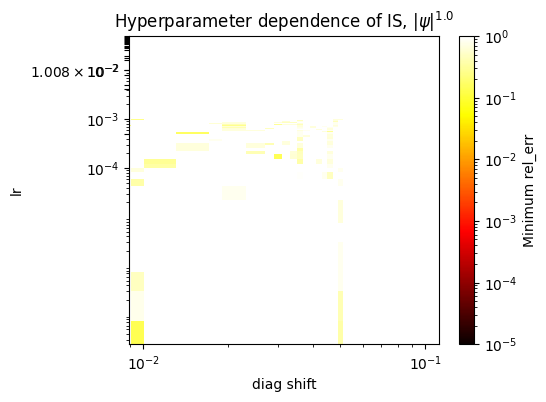

(39, 12)


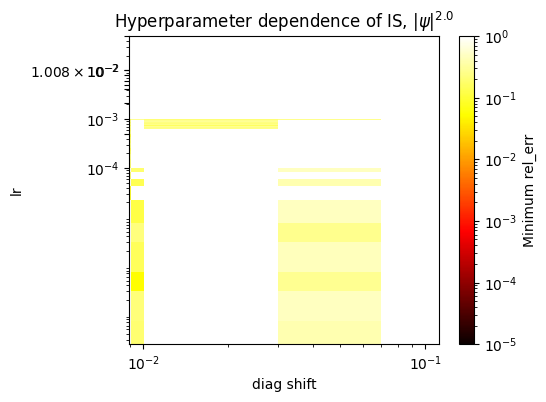

: 

: 

: 

In [5]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib import colors

mc_sample = 9 #2**mc_sample samples
is_keys = [ "0.0",  "0.5", "1.0", "2.0"]
for key in is_keys:
    out_dict = {}
    # Define the main folder
    main_folder = f"/scratch/.amisery/grad_sample_mc_hparams/xxz_1.5/L16/RBM/alpha3/MC_{mc_sample}_{key}"

    # Store the minimum rel_err for each combination of a and b
    rel_err_data = defaultdict(lambda: 100.)

    # Iterate through subfolders
    for subfolder in os.listdir(main_folder):
        subfolder_path = os.path.join(main_folder, subfolder)

        # Check if the subfolder name is in the form a_b
        try:
            a, b = map(float, subfolder.split('_'))
        except ValueError:
            continue  # Skip folders not in the correct format

        # Process run log files in the subfolder
        if os.path.isdir(subfolder_path):
            for file in os.listdir(subfolder_path):
                if file.startswith("run_") and file.endswith(".log"):
                    file_path = os.path.join(subfolder_path, file)
                    try:
                        with open(file_path, 'r') as f:
                            log_data = json.load(f)
                            rel_err = log_data["rel_err"]["value"]
                            if None in rel_err:
                                m = 100
                            else: 
                                m = min(rel_err)
                            rel_err_data[(a, b)] = min(rel_err_data[(a, b)], m)
                    except (json.JSONDecodeError, KeyError):
                        print(f"Warning: Could not parse file {file_path}")

    # Prepare data for the heatmap
    all_a = sorted(set(key[0] for key in rel_err_data.keys()))
    all_b = sorted(set(key[1] for key in rel_err_data.keys()))

    # Create a 2D grid for a and b
    heatmap = np.full((len(all_a), len(all_b)), np.nan)

    for (a, b), rel_err in rel_err_data.items():
        a_idx = all_a.index(a)
        b_idx = all_b.index(b)
        heatmap[a_idx, b_idx] = rel_err

    truncation_index = next((i for i, b in enumerate(all_b) if b > 1e-8), len(all_b))
    heatmap = heatmap[:, truncation_index:]
    all_b = all_b[truncation_index:]
    x = np.array(all_a)
    y= np.array(all_b)
    x_edges = np.concatenate(([x[0] - (x[1] - x[0]) / 2], (x[:-1] + x[1:]) / 2, [x[-1] + (x[-1] - x[-2]) / 2]))
    y_edges = np.concatenate(([y[0] - (y[1] - y[0]) / 2], (y[:-1] + y[1:]) / 2, [y[-1] + (y[-1] - y[-2]) / 2]))


    X,Y = np.meshgrid(x_edges, y_edges)
    print(X.shape)
    
    # Plot the heatmap
    plt.figure(figsize=(5, 4))
    c = plt.pcolormesh(X.T,Y.T, heatmap, cmap='hot', shading='auto',
         norm = colors.LogNorm(vmin=1e-5, vmax=1))
    # c = plt.imshow(heatmap,  cmap='hot', aspect='auto',
    #             extent=(min(all_b), max(all_b), min(all_a), max(all_a)), norm = colors.LogNorm(vmin=1e-5, vmax=1))
    plt.xticks(all_b)
    plt.yscale("log")
    plt.yticks(all_a)
    plt.colorbar(c, label='Minimum rel_err')
    plt.xlabel('diag shift')
    plt.xscale("log")
    plt.ylabel('lr')
    plt.title(r'Hyperparameter dependence of IS, $|\psi|^{%s}$'%key)
    plt.show()


: 

: 

: 

: 

: 

: 

In [6]:
import math

def min_inf(*values):
    """
    Returns the minimum value among the input values.
    If any value is None or NaN, returns float('inf').
    """
    for value in values:
        if value is None or (isinstance(value, float) and math.isnan(value)):
            return float('inf')
    return min(values)

: 

: 

: 

In [7]:
import json
mc_sample = 10 #2**mc_sample samples
is_keys = ["hpsi", "0.0",  "0.5", "1.0", "1.3", "2.0"]
diag_shift = "10_4"
out_dict = {}

for key in is_keys:
    out_dict[key] = {}
    out_dict[key]["rel_err"] = json.load(open(f"/scratch/.amisery/grad_sample/xxz_1.5/L16/RBM/alpha3/MC_{mc_sample}_{key}/saved_{diag_shift}.log"))["rel_err"]
    out_dict[key]["out_path"] = f"/scratch/.amisery/grad_sample/xxz_1.5/L16/RBM/alpha3/MC_{mc_sample}_{key}/saved_{diag_shift}/"

: 

: 

: 

In [8]:
autodiagshift_log = json.load(open("/home/amisery/scratch_link/grad_sample_mc_hparams/xxz_1.5/L16/RBM/alpha3/MC_10/0.001_4.log"))

: 

: 

: 

In [9]:
diag_shift = autodiagshift_log["adaptive_diagshift"]["diag_shift"]
lr = autodiagshift_log["adaptive_diagshift"]["lr"]

: 

: 

: 

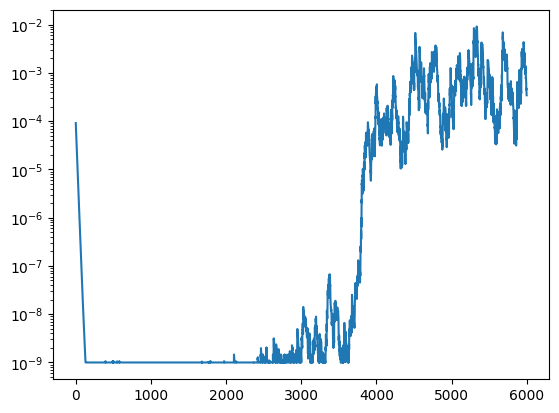

: 

: 

: 

In [10]:
plt.plot(diag_shift["iters"], diag_shift["value"])
plt.yscale("log")

TypeError: unhashable type: 'dict'

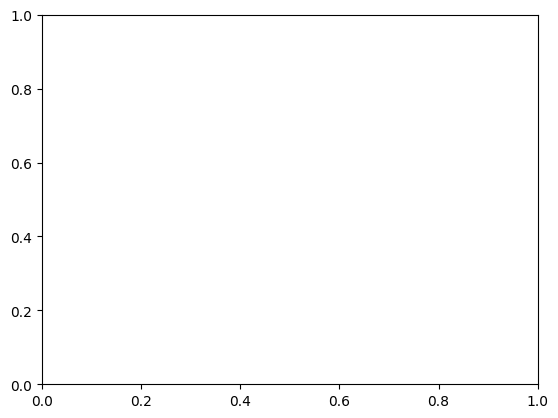

: 

: 

: 

In [11]:
plt.plot(lr["iters"], lr["value"])
plt.yscale("log")

In [15]:
if GlobalHydra().is_initialized():
    GlobalHydra().clear()
with initialize_config_dir(version_base=None, config_dir="/scratch/.amisery/grad_sample/xxz_1.5/L16/RBM/alpha3/MC_10_hpsi/saved_10_3/"):
    cfg = compose(config_name="config")
    print(type(cfg))
    OmegaConf.set_struct(cfg, True)
    print(cfg)
    print(type(cfg.task))
    # cfg = OmegaConf.to_yaml(cfg)
    # take any task from cfg and run it
analysis = Trainer(cfg)

<class 'omegaconf.dictconfig.DictConfig'>
{'device': 6, 'is_mode': 'hpsi', 'solver_fn': {'_target_': 'netket.optimizer.solver.cholesky'}, 'lr': 0.001, 'diag_shift': 0.001, 'n_iter': 8000, 'sample_size': 10, 'chunk_size_jac': 1024, 'chunk_size_vmap': 100, 'save_every': 10, 'base_path': '/scratch/.amisery/grad_sample/', 'model': {'_target_': 'grad_sample.models.heisenberg.XXZ', 'h': 1.5, 'L': 16}, 'ansatz': {'_target_': 'netket.models.RBM', 'alpha': 3, 'param_dtype': 'complex'}, 'task': {'_target_': 'grad_sample.tasks.fullsum_train.Trainer'}}
<class 'omegaconf.dictconfig.DictConfig'>
[CudaDevice(id=0)]
{'_target_': 'netket.models.RBM', 'alpha': 3, 'param_dtype': 'complex'}
MC state loaded, num samples 1024
/scratch/.amisery/grad_sample//xxz_1.5/L16/RBM/alpha3/MC_10_hpsi/saved_10_3
dir created


/scratch/.amisery/netket/lib/python3.11/site-packages/netket/utils/struct/pytree.py:55: UserWarning: Constructing the SR object with `SR(qgt= MyQGTType({'diag_shift', 'diag_scale'}))` can lead to unexpected results and has been deprecated, because the keyword arguments specified in the QGTType are overwritten by those specified by the SR class and its defaults.

To fix this, construct SR as  `SR(qgt=MyQGTType, {'diag_shift': 0.0, 'diag_scale': None})` .

In the future, this warning will become an error.
  obj.__init__(*args, **kwargs)


The ground state energy is: -33.71105604086474


: 

: 

: 

: 